In [11]:
import torch
import torchvision
import numpy as np
import os.path as osp
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import load_alov
import sys
sys.path.append("..")
import numpy as np
import detect
from darknet import Darknet
from utils import *

In [12]:
CUDA = torch.cuda.is_available()
CUDA

True

In [13]:
# GLOBALS
vot_path = "/data/VTB/"

yolo_classes = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['blanket', 'bolt2', 'traffic', 'ball1', 'leaves', 'pedestrian1', 'singer3', 'helicopter', 'godfather', 'soccer1', 'book', 'tunnel', 'gymnastics1', 'basketball', 'birds1', 'car1', 'ball2', 'birds2', 'motocross1', 'bmx', 'gymnastics2', 'fish3', 'motocross2', 'soccer2', 'octopus', 'fernando', 'shaking', 'crossing', 'singer2', 'soldier', 'pedestrian2', 'nature', 'butterfly', 'road', 'iceskater2', 'sphere', 'fish2', 'graduate', 'marching', 'rabbit', 'car2', 'matrix', 'girl', 'tiger', 'gymnastics4', 'wiper', 'racing', 'dinosaur', 'bolt1', 'hand', 'handball1', 'bag', 'sheep', 'iceskater1', 'fish1', 'singer1', 'gymnastics3', 'fish4', 'glove', 'handball2']

vot_classes = [x for x in os.listdir(vot_path) if not x.endswith(".txt")]

print(vot_classes)

['Jumping', 'BlurOwl', 'RedTeam', 'Human4', 'Bolt', 'Surfer', 'Skating2', 'DragonBaby', 'Trellis', 'Ironman', 'Woman', 'Liquor', 'Crowds', 'Deer', 'Car4', 'ClifBar', 'BlurFace', 'Singer2', 'Couple', 'Diving', 'Girl', 'CarDark', 'BlurBody', 'Biker', 'Sylvester', 'Shaking', 'Car1', 'CarScale', 'Walking', 'Walking2', 'Human3', 'BlurCar2', 'Tiger2', 'Skiing', 'Skating1', 'Human9', 'MotorRolling', 'Human6', 'Dudek', 'Jump', 'Bird1', 'Box', 'Panda']


In [14]:
cfgfile = "../cfg/yolo.cfg"
weightfile = "../yolo.weights"
namesfile = '../data/coco.names'
use_cuda=True
m = Darknet(cfgfile).cuda()
m.print_network()
m.load_weights(weightfile)

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64
    4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128
    8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
    9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x  26 x 256
   12 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
   13 conv    256  1 x 

In [15]:
def iou(box_a, box_b):
    # IoU between two boxes
    box_a = box_a[0:4] if len(box_a) != 4 else box_a
    box_b = box_b[0:4] if len(box_b) != 4 else box_b

    x_a = np.max((box_a[0], box_b[0]))
    y_a = np.max((box_a[1], box_b[1]))
    x_b = np.min((box_a[2], box_b[2]))
    y_b = np.min((box_a[3], box_b[3]))

    inter_area = np.max((0., x_b - x_a + 1)) * np.max((0., y_b - y_a + 1))
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    a = (box_a_area + box_b_area - inter_area)
    res = inter_area / a
    return res


def choose_best_by_emb(prev, candidates, thr=.3):
    best_dist = thr
    best_track_idx = 0
    prev_emb = np.array(prev[7:-2])
    
    for n, candidate in enumerate(candidates):
        cand_emb = np.array(candidate[7:-2])
        emb_dist = torch.mean((cand_emb[0] - prev_emb[0]) ** 2)
        if emb_dist < best_dist:
            best_dist = emb_dist
            best_track_idx = n
    
    if best_dist < thr:
        return candidates[best_track_idx]
    return prev

def best_iou(candidates, gt, width=None, height=None):
    best_iou = 0
    best_index = 0
    for i, candidate in enumerate(candidates):
        c = candidate
        if len(c) > 4:
            c = c[0:4]
        if width is not None:
            x1 = (c[0] - c[2] / 2.0) * width
            y1 = (c[1] - c[3] / 2.0) * height
            x2 = (c[0] + c[2] / 2.0) * width
            y2 = (c[1] + c[3] / 2.0) * height
            c = np.array([x1, y1, x2, y2])
        _iou = iou(c, gt)
        if _iou > best_iou:
            best_iou = _iou
            best_index = i
    
    return candidates[best_index] if best_iou > 0 else None

def file2tensor(file):
    with open(file, 'r') as f:
        tens = torch.tensor([[float(y) for y in x.split(',')] for x in f.readlines()])
        if len(tens) < 4:
            tens = torch.tensor([[float(y) for y in x.split()] for x in f.readlines()])
        return tens
    
def read_gt(file, idx=None):
    tensor = file2tensor(file)
    if idx is not None:
        return tensor[idx]
    else:
        return tensor
    
def force_square(m):
    return [min(m[::2]), min(m[1::2]), max(m[::2]), max(m[1::2])]

In [16]:
def plot_single(im, box=None, line="r-", resize=False, noshow=False):
    if not noshow:
        plt.imshow(im)

#     if pr_path is not None:
#         with open(pr_path, 'r') as f:
#             l = f.read().split("\n")[pr_idx]
#             if l == "":
#                 return
#             pr_bb = [float(x) for x in l.split(',')]

#         if (force_square):
#             X, Y = pr_bb[::2], pr_bb[1::2]
#             pr_bb = [min(X), min(Y), max(X),  max(Y)]
#             plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
#                      [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
#         elif (len(pr_bb) == 8):
#             plt.plot(pr_bb[::2] + [pr_bb[0]],
#                      pr_bb[1::2] + [pr_bb[1]], 'r-', lw=2)
#         else:
#             plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
#                      [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

    if box is not None and resize:  
        width, height = im.width, im.height
        x1 = (box[0] - box[2] / 2.0) * width
        y1 = (box[1] - box[3] / 2.0) * height
        x2 = (box[0] + box[2] / 2.0) * width
        y2 = (box[1] + box[3] / 2.0) * height
    else:
        if len(box) > 4:
            box = force_square(box)
        x1, y1, x2, y2 = box
    if not noshow:
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], line, lw=2)

    return [x1, y1, x2, y2]    

In [17]:
def change_bb_format(bb):
    w, h, x, y = bb
    x1 = x
    x2 = x + w
    y1 = y
    y2 = y + h
    return torch.tensor([x1, y1, x2, y2])

Jumping
Jumping,score tensor(0.1386, dtype=torch.float64)


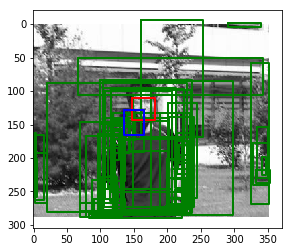

score tensor(0.0744, dtype=torch.float64)


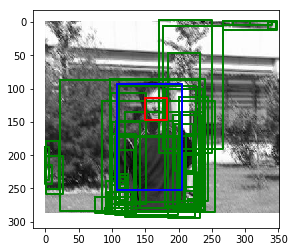

score tensor(0.0326, dtype=torch.float64)


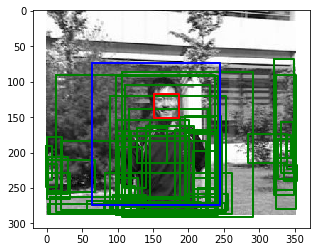

score tensor(0.0660, dtype=torch.float64)


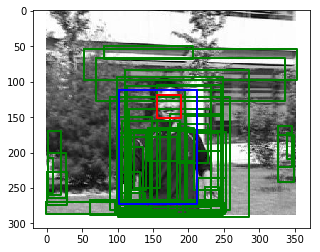

score tensor(0.0349, dtype=torch.float64)


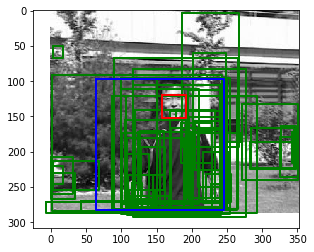

score tensor(0.0299, dtype=torch.float64)


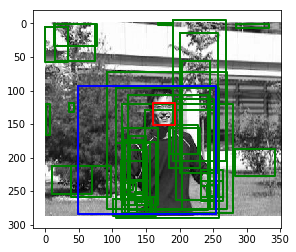

score tensor(0., dtype=torch.float64)


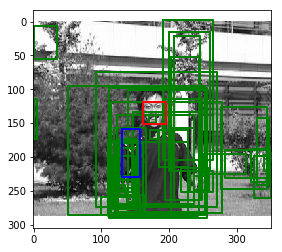

score tensor(0., dtype=torch.float64)


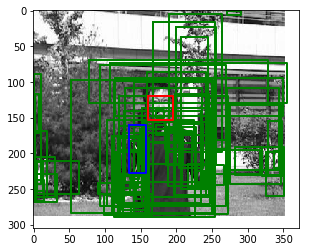

score tensor(0., dtype=torch.float64)


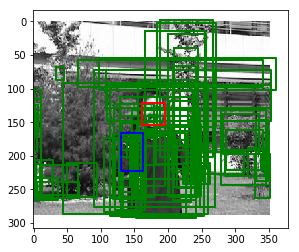

score tensor(0., dtype=torch.float64)


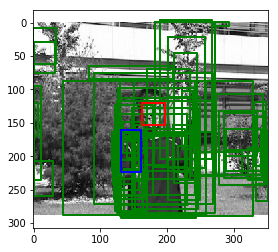

score tensor(0., dtype=torch.float64)


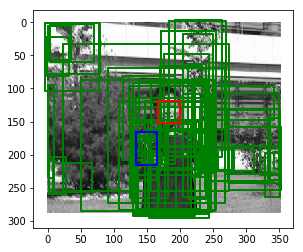

score tensor(0., dtype=torch.float64)


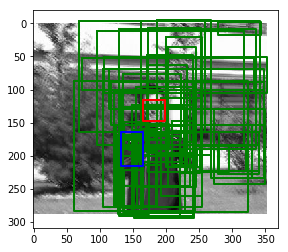

score tensor(0.0345, dtype=torch.float64)


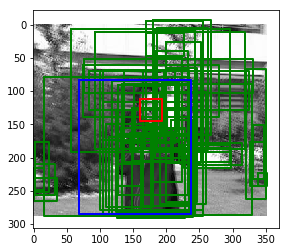

score tensor(0.0377, dtype=torch.float64)


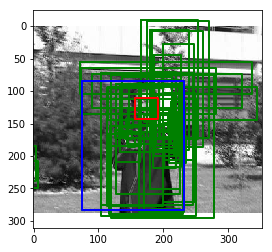

score tensor(0.0363, dtype=torch.float64)


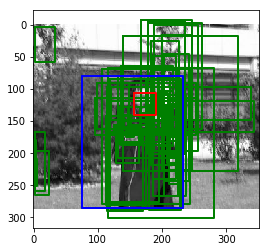

score tensor(0.0308, dtype=torch.float64)


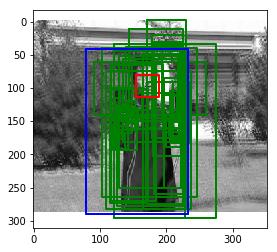

score tensor(0.0686, dtype=torch.float64)


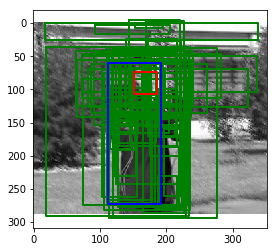

score tensor(0.0523, dtype=torch.float64)


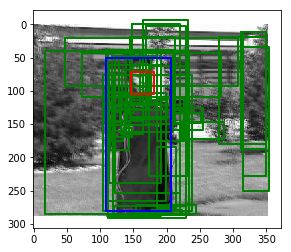

score tensor(0., dtype=torch.float64)


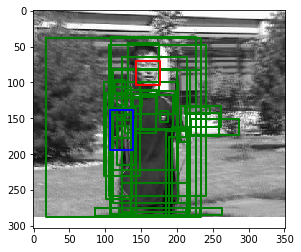

score tensor(0.0236, dtype=torch.float64)


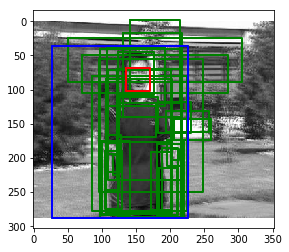

score tensor(0.0286, dtype=torch.float64)


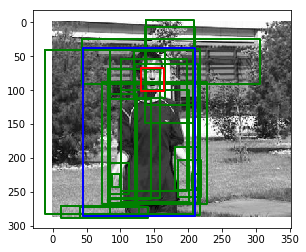

score tensor(0.0645, dtype=torch.float64)


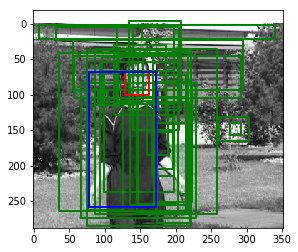

score tensor(0.0540, dtype=torch.float64)


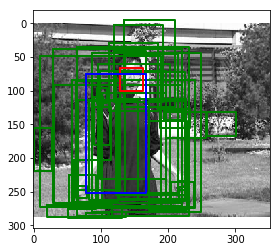

score tensor(0.0263, dtype=torch.float64)


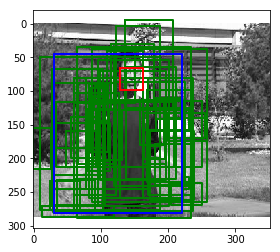

score tensor(0.0327, dtype=torch.float64)


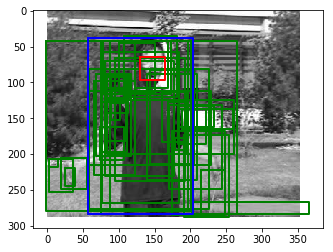

score tensor(0.0220, dtype=torch.float64)


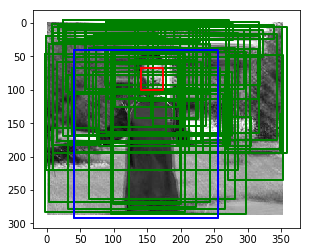

score tensor(0.0188, dtype=torch.float64)


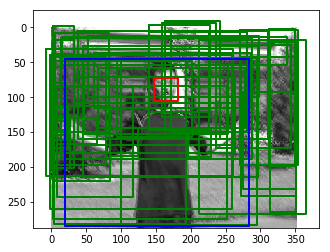

score tensor(0.0717, dtype=torch.float64)


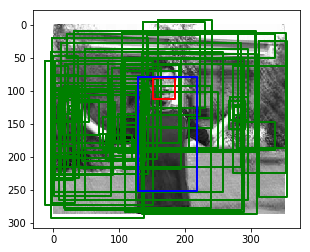

score tensor(0.0231, dtype=torch.float64)


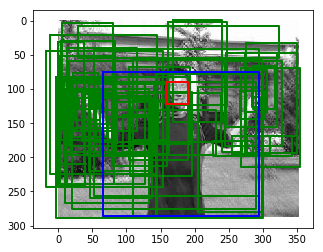

score tensor(0.0241, dtype=torch.float64)


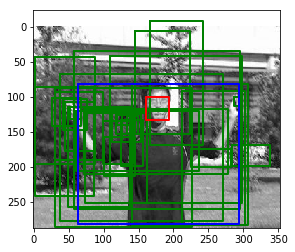

score tensor(0.0268, dtype=torch.float64)


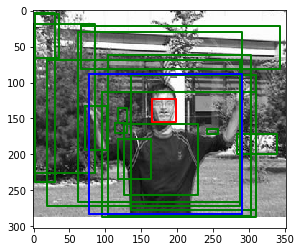

score tensor(0.0286, dtype=torch.float64)


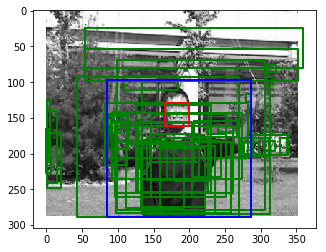

score tensor(0., dtype=torch.float64)


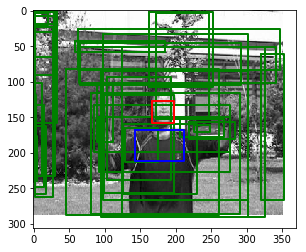

score tensor(0.0574, dtype=torch.float64)


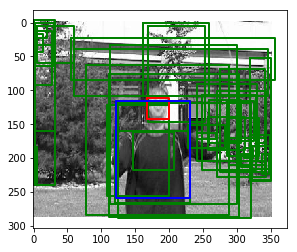

score tensor(0.0149, dtype=torch.float64)


KeyboardInterrupt: 

In [24]:
hero = None
plot = 1

d = dict()
for vot_class in vot_classes:
    print(vot_class)
    d[vot_class] = list()
    
    print(vot_class, end=",")
    
    image_paths = [osp.join(vot_path, vot_class, 'img', x) for x in [y for y in sorted(os.listdir(osp.join(vot_path, vot_class, 'img'))) if y.endswith("jpg")]]
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path).convert('RGB')
        sized = image.resize((m.width, m.height))
        boxes = do_detect(m, sized, 0.002, 0.75, use_cuda)
        if plot:
            for box in boxes:
                plot_single(image, box, line="g-", resize=True)
        gt = force_square(read_gt(osp.join(vot_path, vot_class, "groundtruth_rect.txt"), i)) 
        gt = change_bb_format(gt)
        
        if plot:
            plot_single(image, gt, line="r-")
        
        if hero is None:
            hero = best_iou(boxes, gt, image.width, image.height)
        else:
            hero = choose_best_by_emb(hero, boxes)
        
        res = plot_single(image, hero, 'b-', resize=True, noshow=not plot)
        score = iou(res, gt)
        d[vot_class].append(score)
        
        if not plot:
            print(float(score), end=",", file=open("vtb_results/{}.csv".format(vot_class), 'a+'))
            print(",".join([str(float(x)) for x in res]), file=open("vtb_predictions/{}.csv".format(vot_class), 'a+'))
        print("score",score)
              
        plt.show()
        plt.close()

Jumping,score tensor(0.0596, dtype=torch.float64)


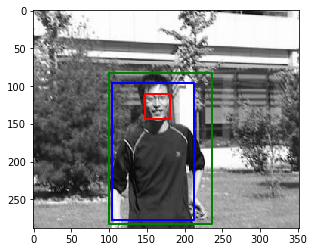

score tensor(0.0414, dtype=torch.float64)


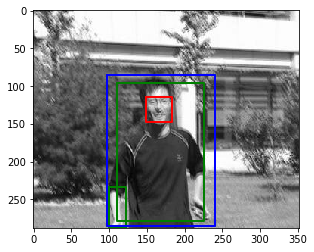

score tensor(0.0415, dtype=torch.float64)


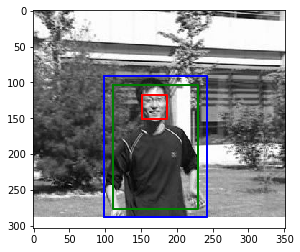

score tensor(0.0404, dtype=torch.float64)


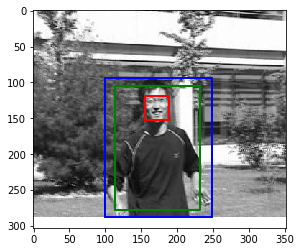

score tensor(0.0391, dtype=torch.float64)


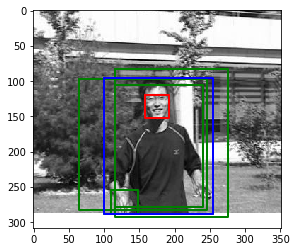

score tensor(0.0396, dtype=torch.float64)


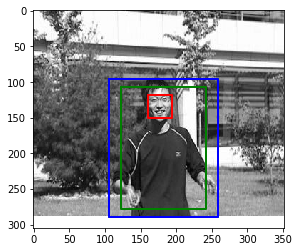

score tensor(0.0423, dtype=torch.float64)


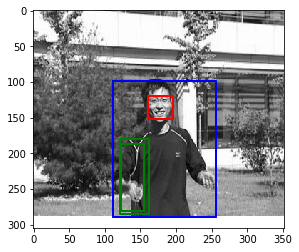

score tensor(0.0435, dtype=torch.float64)


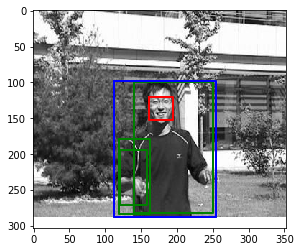

score tensor(0.0435, dtype=torch.float64)


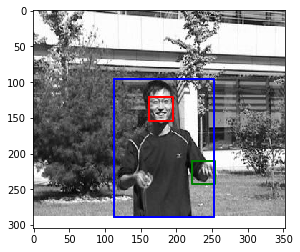

score tensor(0.0540, dtype=torch.float64)


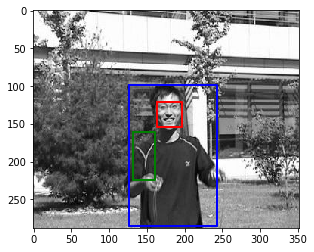

score tensor(0.0519, dtype=torch.float64)


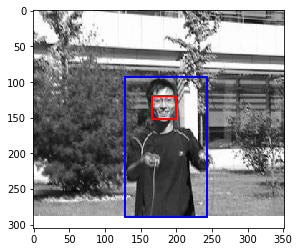

score tensor(0.0521, dtype=torch.float64)


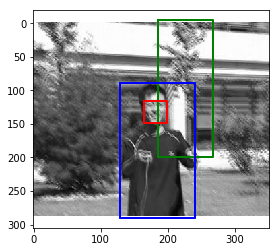

score tensor(0.0469, dtype=torch.float64)


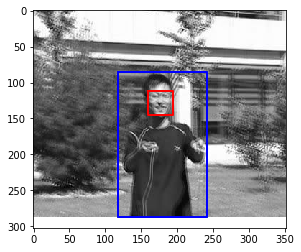

score tensor(0.0523, dtype=torch.float64)


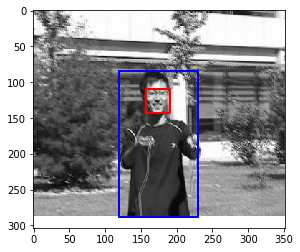

score tensor(0.0525, dtype=torch.float64)


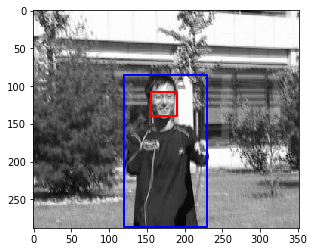

score tensor(0.0436, dtype=torch.float64)


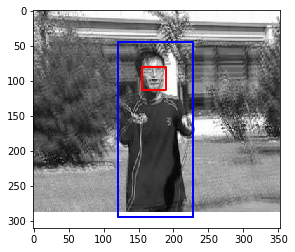

score tensor(0.0402, dtype=torch.float64)


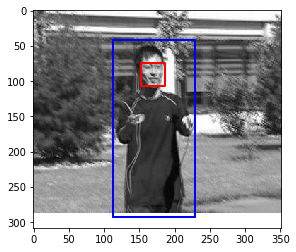

score tensor(0.0400, dtype=torch.float64)


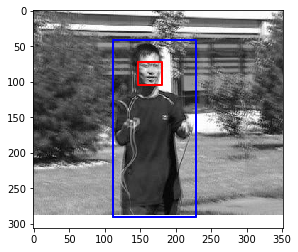

score tensor(0.0396, dtype=torch.float64)


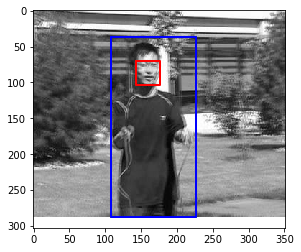

score tensor(0.0399, dtype=torch.float64)


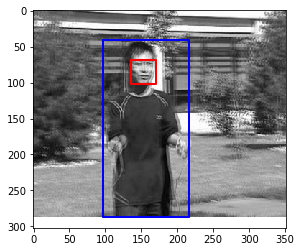

score tensor(0.0358, dtype=torch.float64)


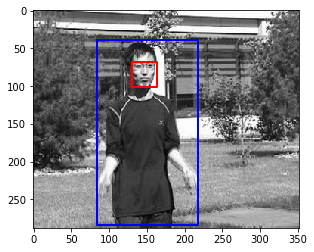

score tensor(0.0323, dtype=torch.float64)


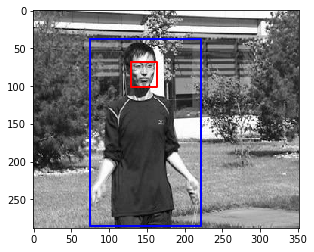

score tensor(0.0283, dtype=torch.float64)


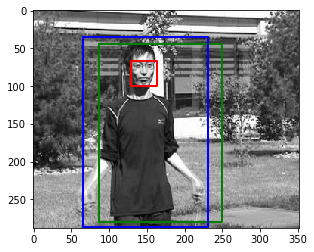

score tensor(0.0274, dtype=torch.float64)


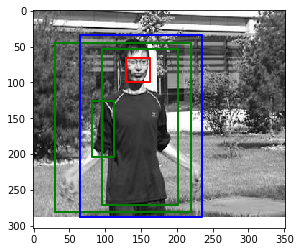

score tensor(0.0459, dtype=torch.float64)


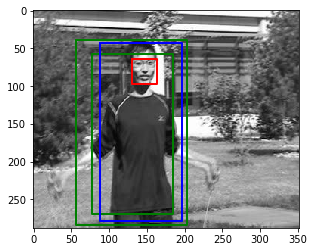

score tensor(0.0220, dtype=torch.float64)


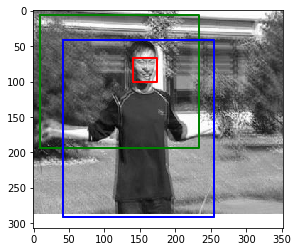

score tensor(0.0188, dtype=torch.float64)


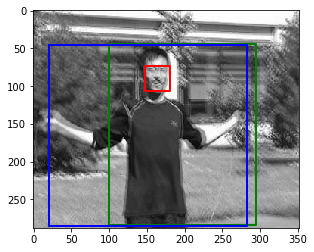

score tensor(0.0186, dtype=torch.float64)


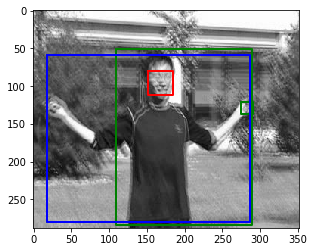

score tensor(0.0221, dtype=torch.float64)


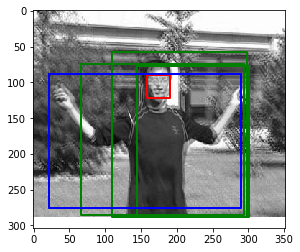

score tensor(0.0241, dtype=torch.float64)


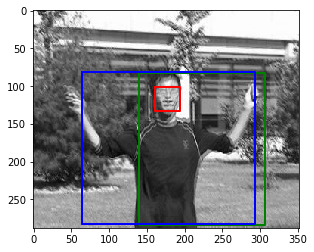

score tensor(0.0268, dtype=torch.float64)


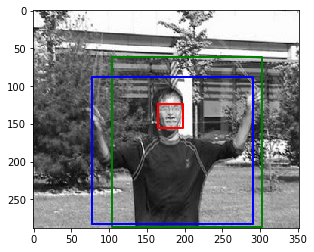

score tensor(0.0286, dtype=torch.float64)


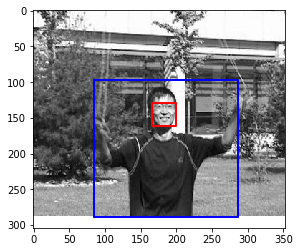

score tensor(0.0238, dtype=torch.float64)


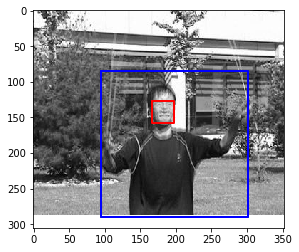

score tensor(0.0259, dtype=torch.float64)


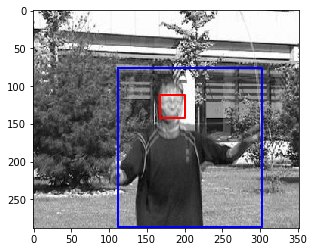

KeyboardInterrupt: 

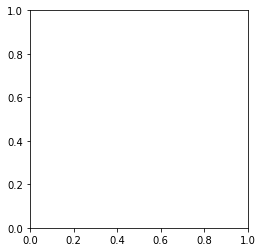

In [27]:
hero = None
plot = 1

d = dict()
for vot_class in vot_classes:
    print(vot_class, end=",n")
    d[vot_class] = list()    
    
    image_paths = [osp.join(vot_path, vot_class, 'img', x) for x in [y for y in sorted(os.listdir(osp.join(vot_path, vot_class, 'img'))) if y.endswith("jpg")]]
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path).convert('RGB')
        sized = image.resize((m.width, m.height))
        boxes = do_detect(m, sized, 0.2, 0.75, use_cuda)
        if plot:
            for box in boxes:
                plot_single(image, box, line="g-", resize=True)
        gt = force_square(read_gt(osp.join(vot_path, vot_class, "groundtruth_rect.txt"), i)) 
        gt = change_bb_format(gt)
        
        if plot:
            plot_single(image, gt, line="r-")
        
        if hero is None:
            hero = best_iou(boxes, gt, image.width, image.height)
        else:
            hero = choose_best_by_emb(hero, boxes)
        
        res = plot_single(image, hero, 'b-', resize=True, noshow=not plot)
        score = iou(res, gt)
        d[vot_class].append(score)
        
        if not plot:
            print(float(score), end=",", file=open("vtb_results/{}.csv".format(vot_class), 'a+'))
            print(",".join([str(float(x)) for x in res]), file=open("vtb_predictions/{}.csv".format(vot_class), 'a+'))
        print("score",score)
              
        plt.show()
        plt.close()

In [125]:
np.mean(a)

0.08777316776337443